# Telia andmeteaduse kodutöö

## Ülesanne

Telia andmeteaduse kodutöö eesmärk on ennustada telekommunikatsiooni ettevõttest lahkuvaid kliente. Selleks kasutatakse Telco kliendi lahkumise andmestikku, mis sisaldab klientide teenuste tellimuse olekut, kontodetaile, demograafilisi andmeid ja lahutussammast, mis näitab, kas klient on lahkunud või mitte.  Kodutöö raames viin läbi andmete analüüsi ja eeltöötluse ja seejärel loon ennustatava mudeli, kasutades logistilist regressiooni. Lõpuks hindan mudeli jõudlust kasutades erinevaid hindamismeetodeid, sealhulgas mudeli täpsust, segadusmaatriksit ja klassifikatsiooni raportit.

## Lahendus
1. Andmete analüüs
2. Andmete eeltöötlus
3. Mudeli loomine kasutades logistilist regressiooni
4. Mudeli hindamine kasutades mudeli täpsust, segadusmaatriksit ja klassifikatsiooni raportit

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import itertools 

## Andmete analüüs

In [379]:
# Loen andmed
andmed = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
# Prindin andmestiku 5 esimest rida
andmed.head()

In [ ]:
# Vaatan millist tüüpi on iga veerg
andmed.info()

In [ ]:
# TotalCharges peaks olema numbritüüp
andmed['TotalCharges'] = pd.to_numeric(andmed['TotalCharges'], errors='coerce')

# Kontrollin iga veeru andmetüüpe, et kinnitada teisendus
andmed.info()

In [383]:
# Kontrollin palju on puuduvaid väärtusi
andmed.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Tulemusena on 11 arvu puudu "Total Charges" veerust.

In [384]:
# Eemaldan puuduvad arvud TotalCharges veerust
andmed = andmed.dropna().reset_index(drop=True)

In [ ]:
# Kontrollin uuesti palju on puuduvaid väärtusi
andmed.isnull().sum()

In [386]:
# Kokkuvõte numbriliste muutujate kohta
andmed.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [387]:
# Kokkuvõte kategooriliste muutujate kohta
andmed.describe(include = ['object'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,7032,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3549,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365,5163


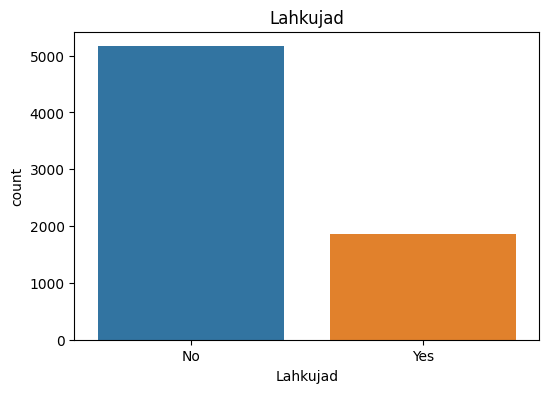

In [388]:
# Visualiseerin Churn veeru jaotuse
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=andmed)
plt.title('Lahkujad')
plt.xlabel('Lahkujad')
plt.show()

Andmestikus on rohkem mitte lahkujaid.

array([<Axes: ylabel='Month-to-month'>, <Axes: ylabel='One year'>,
       <Axes: ylabel='Two year'>], dtype=object)

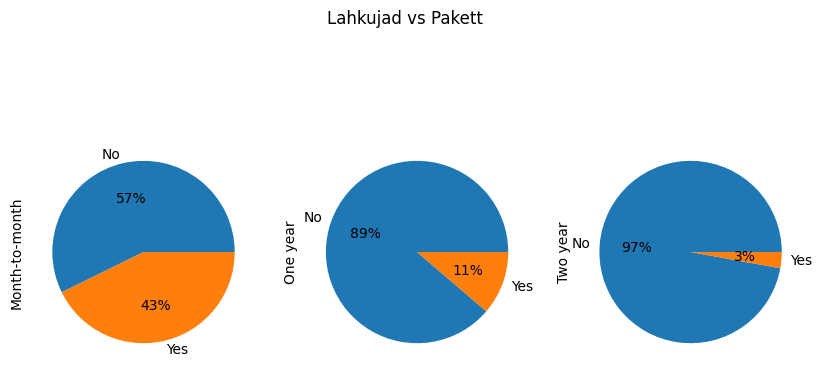

In [389]:
andmed.groupby(['Churn','Contract']).size().unstack().plot(kind='pie',subplots=True, 
title='Lahkujad vs Pakett' , autopct='%1.0f%%', figsize=(10, 5), legend = False)

Enamus lahkujatel on "Month-to-month" pakett. Kasutajatel, kellel on kahe aastane pakett on ettevõttele lojaalsemad.

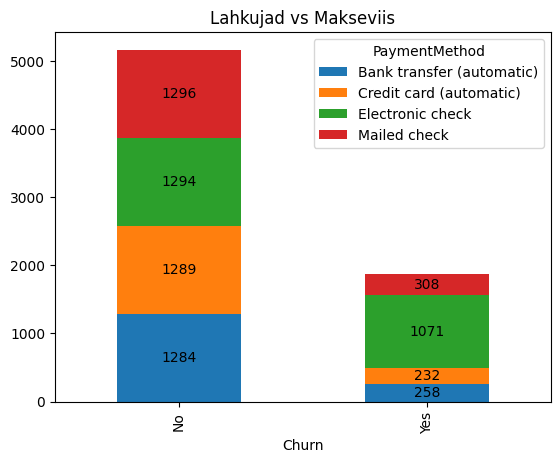

In [390]:
tabel = andmed.groupby(['Churn','PaymentMethod']).size().unstack().plot(kind='bar', title='Lahkujad vs Makseviis' , stacked = True)
for container in tabel.containers:
  labels = [int(v.get_height()) for v in container]
  tabel.bar_label(container, labels=labels, label_type='center')

Kasutajad kes maksavad interneti kaudu lahkuvad kergemalt võrreldes teiste makseviisidega.

Churn
No     Axes(0.125,0.11;0.775x0.77)
Yes    Axes(0.125,0.11;0.775x0.77)
Name: MonthlyCharges, dtype: object

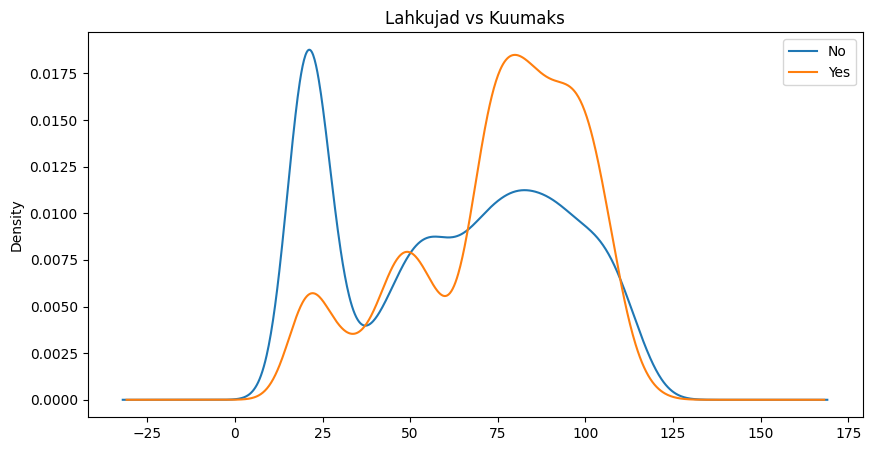

In [391]:
andmed.groupby(['Churn'])['MonthlyCharges'].plot(kind='density', title='Lahkujad vs Kuumaks' , figsize=(10, 5), legend= True)

Kasutajad kellel on kõrgem kuumaks lahkuvad suurema tõenäosusega.

Churn
No     Axes(0.125,0.11;0.775x0.77)
Yes    Axes(0.125,0.11;0.775x0.77)
Name: tenure, dtype: object

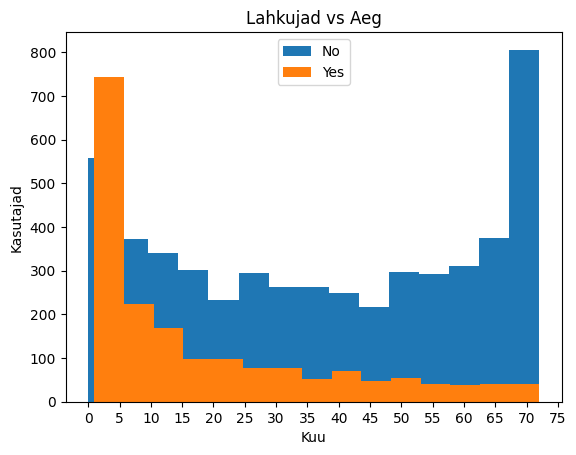

In [358]:
andmed.groupby(['Churn'])['tenure'].plot(kind='hist', title='Lahkujad vs Aeg', legend=True, xticks=np.arange(0, 80, step=5), bins=15, ylabel='Kasutajad',xlabel='Kuu')

Kasutajad lahkuvad suurema tõenäosusega esimese paari kuu jooksul. Peale kuute kuud on lahkumise tõenäosus juba palju väiksem.

array([<Axes: ylabel='Female'>, <Axes: ylabel='Male'>], dtype=object)

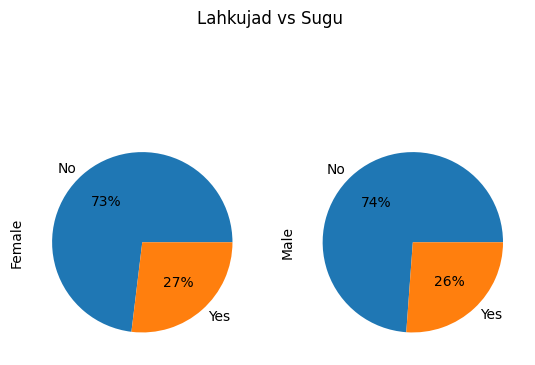

In [359]:
andmed.groupby(['Churn','gender']).size().unstack().plot(kind='pie',subplots=True, title='Lahkujad vs Sugu' , autopct='%1.0f%%', legend = False)

Meeste ja naiste lahkumise trend on väga sarnane.

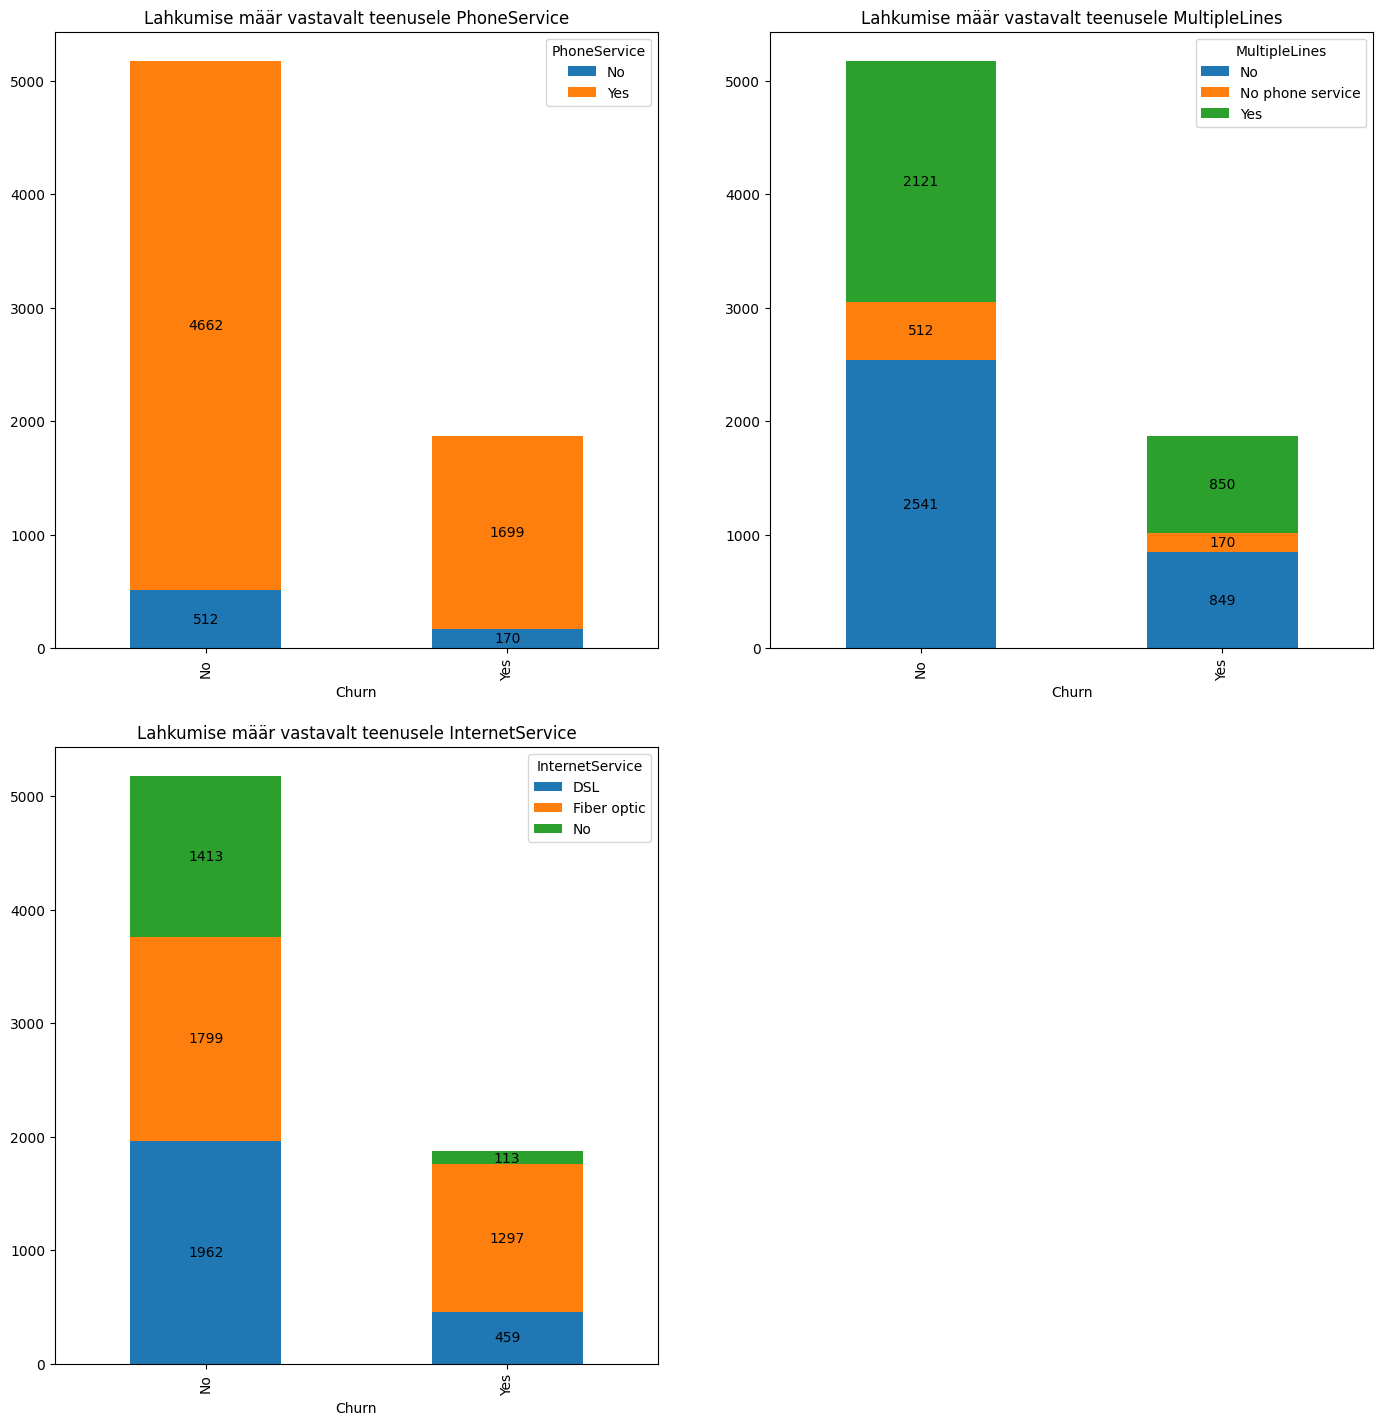

In [360]:
teenused = ['PhoneService', 'MultipleLines', 'InternetService']
fig, axed = plt.subplots(2, 2, figsize=(15, 15))
fig.tight_layout(pad=5.0)
k = 0
for i in range(2):
    for j in range(2):
        if k < len(teenused):  # Kas indeks on saadaolevate teenuste ulatuses
            ax = andmed.groupby(['Churn', teenused[k]]).size().unstack().plot(kind='bar', stacked=True,
                                                                              title='Lahkumise määr vastavalt teenusele ' + teenused[k],
                                                                              ax=axed[i, j])
            for container in ax.containers:
                labels = [int(v.get_height()) for v in container]
                ax.bar_label(container, labels=labels, label_type='center')
            k += 1  # Suurenda indeksit ainult siis, kui on plotted
        else:
            axed[i, j].axis('off')  # Kui teenuseid pole -> shut down axis

Teenused nagu "Phone Service", "Multiple Lines" ja "Internet Service" näitavad sarnaseid trende mitte lahkujate ja lahkujate kohta.

## Andmete eeltöötlus

Andmestikus on palju kategoorilisi veerge, mis omavad erinevaid väärtusi. Oluline on standardiseerida need veerud, et neid oleks hiljem mudeli loomisel kergem rakendada.

Näiteks Gender veeru väärtusteks on Female või Male, samas kui Partneri veerg on Yes või No.

In [ ]:
# Saan kõik veerud kus väärtused on Yes/No
# Uued väärtused Yes -> 1, No -> 0
yesno_veerud = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']
yesno_veerud_andmed = andmed.loc[:,yesno_veerud]
yesno_veerud_andmed.replace(['Yes','No'], [1,0], inplace=True)
yesno_veerud_andmed.head()

In [ ]:
# Ülejäänud muutujatele loon "dummy" veerud
dummy_andmed = andmed.drop(yesno_veerud, axis=1)
dummy_andmed = pd.get_dummies(dummy_andmed)
dummy_andmed.head()

In [394]:
# Ühendasin kõik töödeldud veerud ühte andmestikku
toodeldud_andmed = pd.concat([dummy_andmed, yesno_veerud_andmed], axis=1)
toodeldud_andmed.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_0002-ORFBO,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,0,1,29.85,29.85,False,False,False,False,False,False,...,False,False,False,True,False,1,0,0,1,0
1,0,34,56.95,1889.50,False,False,False,False,False,False,...,False,False,False,False,True,0,0,1,0,0
2,0,2,53.85,108.15,False,False,False,False,False,False,...,False,False,False,False,True,0,0,1,1,1
3,0,45,42.30,1840.75,False,False,False,False,False,False,...,False,True,False,False,False,0,0,0,0,0
4,0,2,70.70,151.65,False,False,False,False,False,False,...,False,False,False,True,False,0,0,1,1,1


## Mudeli loomine

Mudeli ehitamiseks kasutan logistilist regressiooni, mis on üks tihti kasutatavaid klassifitseerimise algoritme. 

Kuidas mudel toimib:
1. Mudelil on omadused (X), ja sihtmärgid (y), mida tuleb ennustada. 
2. Mudel kasutab treeningandmeid, et õppida seost omaduste ja sihtmärkide vahel. 
3. Mudel suudab ennustada testimisandmeid.

In [395]:
# Eraldan omadused (X) ja sihtmärgid (y)
# Omadused on kõik töödeldud andmed väljaarvatud "Churn" veerg
X = toodeldud_andmed.drop('Churn', axis=1)
y = toodeldud_andmed['Churn']

In [396]:
# Jagan andmed treening- ja testimisandmeteks. 20% andmetest jääb testimiseks ja 80% treenimiseks.
# random_state parameeter määrab juhuarvu generaatori algseisundis.
X_trenn, X_test, y_trenn, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Loon ja koolitan logistiline regressiooni mudeli kasutades treenimisandmeid.
mudel = LogisticRegression(max_iter=1000) 
mudel.fit(X_trenn, y_trenn)

In [398]:
# Ennustustan testimisandmetel
y_ennustus = mudel.predict(X_test)

## Mudeli hindamine

Mudeli hindamiseks kasutan mudeli täpsust, segadusmaatriksit ja klassifikatsiooni raportit.


In [399]:
# Mudeli täpsus
tapsus = accuracy_score(y_test, y_ennustus)
print("Mudeli täpsus:", tapsus)

Mudeli täpsus: 0.7924662402274343


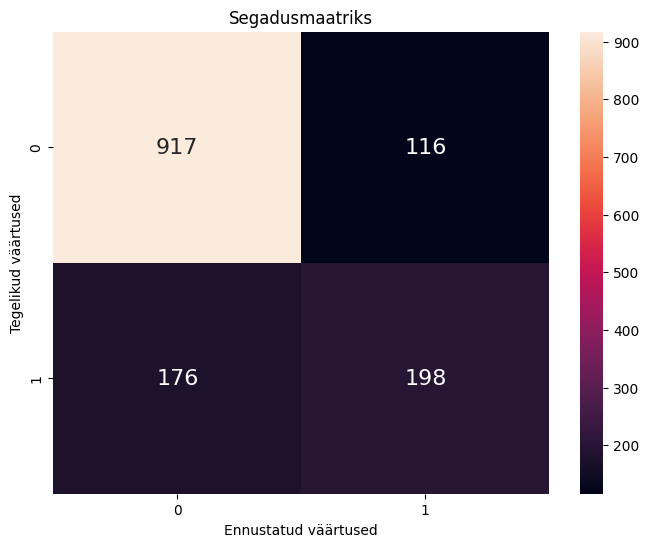

In [400]:
# Mudeli segadusmaatriks
segadusmat = confusion_matrix(y_test, y_ennustus)
plt.figure(figsize=(8, 6))
sns.heatmap(segadusmat, annot=True, fmt='d', annot_kws={"size": 16})
plt.xlabel('Ennustatud väärtused')
plt.ylabel('Tegelikud väärtused')
plt.title('Segadusmaatriks')
plt.show()

In [401]:
# Klassifikatsiooni raport
klass_rap = classification_report(y_test, y_ennustus)
print("\nKlassifikatsiooni raport:")
print(klass_rap)


Klassifikatsiooni raport:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



Mudeli täpsus näitab kui hästi suudab mudel õigesti klassifitseerida andmeid. Minu mudeli täpsus oli umbes 79,2%, ehk ligikaudu 79,2% testimisandmetest suudab minu mudel õigesti klassifitseerida. Segadusmaatriksi hindamisel on näha, et mudelil on kõrgem tundlikkus mitte lahkujate suhtes ja madalam tundlikkus lahkujate suhtes. See tähendab, et mudel klassifitseerib rohkem mitte lahkujaid (klass 0) õigesti kui lahkujaid (klass 1). Klassifikatsiooni raport annab üksikasjalikumat teavet mitte lahkujate ja lahkujate täpsuse, tundlikkuse ja F1-skoori kohta. Mudel suudab umbes 89% mitte lahkujatest ja 52% lahkujatest õigesti tuvastada. Üldiselt näitavad tulemused, et mudel suudab teha adekvaatseid ennustusi kliendi lahkumise kohta, kuid täiustused nagu näiteks andmete tasakaalustamine või mitme mudeli kombinatsiooni kasutamine aitaksid paremini tuvastada potentsiaalsed lahkujad.